<font size="3"> By Group 4: Qianjing Liang, Elouise Matthews, Naman Ratra, and Luis Sejas <font>

# Table of Contents

## [Overview](#chapter1)
## [Part I. Base case](#chapter2)
## [Part II. Study the effect of removing the S and R curves](#chapter3)
## [Conclusion](#chapter4)

# Overview: <a class="anchor" id="chapter1"></a>
All the studied cases here will use the same assumptions which will be laid out in the next part

## Steps:
1. Study the base case (i.e. the 1st task): infer the death rate $\mu$ by using all four curves of S, I, R, and D (after adding lognormal multiplicative noises). The structure of the pymc3 model will be changed to compare the results of different prior distributions.
2. Using the best combination from the first step (i.e. the best prior distributions), build a new pymc3 model without the input of the S and R curves to see if the inference of $\mu$ still works.

## Assumptions:
- $\gamma$ = 1, $\beta$ = 2.5


- The total population (N) = 1


- Initial conditions:
    - $i_{0}$ = 0.01 (fractions infected at time t=0),

    - $s_{0}$ = 0.99,

    - $r_{0}$ = 0 (fraction of recovered at time t=0)
    
    
- Time related variables:
    - $d_{0}$ = 0,

    - $f$ = 4.5 (time factor that defines total time window range),

    - timestep = 0.5
    
    
- Variances:
    - $\sigma \in (0.2, 0.4)$

    - Considering that in general, the I compartment has a higher variance compared to the R and D compartments, the sigmas in this notebook will be set as:
        $\sigma_{S}$ = 0.25, $\sigma_{I}$ = 0.38, $\sigma_{R}$ = 0.22, $\sigma_{D}$ = 0.20


- $R_{0}$ (R nought):
    - Since $R_{0}$ (R nought) = $\frac {\beta}{\gamma + \mu}$, $\gamma$ = 1, $\beta$ = 2.5, $R_{0}$ (R nought) = $\frac {2.5}{1 + \mu}$

    - Therefore, $\mu$ = $\frac{2.5}{R_{0}}$-1


- Value ranges of $R_{0}$ (R nought) and $\mu$:
    - Given the relationship between the death rate $\mu$ and $R_{0}$ (R nought), and it is obvious that $\mu \in [0, 1]$, the range for $R_{0}$ (R nought) can also be inferred. 

    - By combining these two expressions, it turns out that $R_{0}$ (R nought) $\in [1.25, 2.5]$ This value range will be applied later in the MCMC model, where a bounded prior distribution is assumed for $R_{0}$ (R nought)

## Note:
- While the goal of performing MCMC is to infer the death rate $\mu$, the actual process shown here is for inferring the $R_{0}$ (R nought), and therefore posterior distributions of $R_{0}$ (R nought) will be presented instead.

- Considering the assumption of this notebok, this is essentially the same as inferring the death rate $\mu$. As mentioned before, as $\gamma$ is fixed to be 1, $R_{0}$ (R nought) = $\frac {2.5}{1 + \mu}$. Therefore, once $R_{0}$ (R nought) can be inferred, the death rate $\mu$ can also be determined.

In [1]:
# Import Python packages
import pandas as pd
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%precision 4 
%matplotlib inline

import pymc3 as pm
from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint

import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore") 
simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Import two python files made for this assignment (should be 
# in the same folder), more descriptions can be found in
# these two .py files
from SIRD import SIRD, IRD, SID
from MCMC import MCMC, MCMC_model

In [3]:
# Define initial conditions of SIRD model
i0, r0, d0 = 0.01, 0.00, 0.00
s0 = 1-i0-r0-d0

# Time-related definitions
f, timestep_data = 4.5, 0.5
times = np.arange(0,5*f,timestep_data)

# Assumptions of infection rate, recovery rate, and sigmas of
# noises for the SIRD curves
beta, gamma = 2.5, 1
sigmas = [0.25, 0.38, 0.22, 0.20]

# Ground truth (fixed gamma=1 and beta=2.5, then R0=2.5/(1+mu), 
# time scale to t/gamma)
mu = 0.5
R0 = 2.5/(1+mu)

# Part I. Base case <a class="anchor" id="chapter2"></a>

Goal: infer the death rate $\mu$, given noisy $S(t)$, $I(t)$, $R(t)$, $D(t)$ input curves.

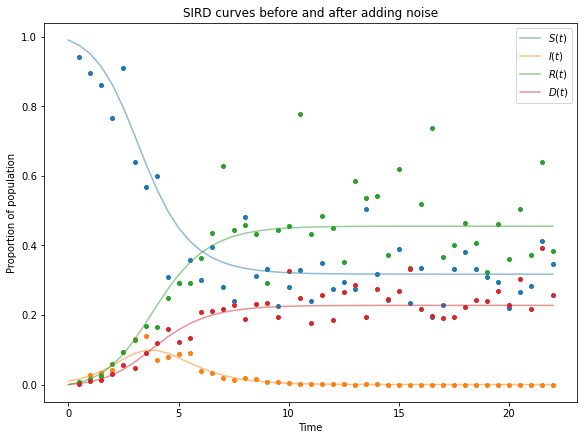

In [4]:
y = odeint(SIRD, t=times, y0=[s0, i0, r0, d0], 
           args=([2.5/(1+mu)],), rtol=1e-8)

yobs = np.zeros([len(times)-1,np.shape(y)[1]])
# To avoid situations where the value of S/I/R/D, after adding noise,
# become larger than 1 (which is not realistic, as S/I/R/D represent
# the proportion of the population), a multiplicative noise is added
# to each data point of the four curves in turn:
for i in range(np.shape(y)[1]):
    for j in range(len(times)-1):
        while True:
            yobs[j,i] = np.random.lognormal(mean=np.log(y[j+1,i]), 
                                            sigma=sigmas[i])
            if yobs[j,i]<=1: # check if the noise added data point is realistic
                break
        
fig1, ax1 = plt.subplots(1,1,figsize=(8,6),constrained_layout=True)
ax1.plot(times[1::], yobs, marker='o', linestyle='none', markersize=4)
ax1.plot(times, y[:,0], color ='C0', alpha=0.5, label=f'$S(t)$')
ax1.plot(times, y[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
ax1.plot(times, y[:,2], color='C2', alpha=0.5, label=f'$R(t)$')
ax1.plot(times, y[:,3], color ='C3', alpha=0.5, label=f'$D(t)$')

ax1.legend()
ax1.set_title('SIRD curves before and after adding noise')
ax1.set_xlabel('Time')
ax1.set_ylabel('Proportion of population')

plt.show()

In [5]:
# ODE system container
sird_model = DifferentialEquation(
    func=SIRD,
    times=np.arange(timestep_data,5*f,
                    timestep_data), # start at t=t_1 (not t0=0 
                                    # where log(R=0)=undef)
    n_states=4, # S, I, R, and D are states
    n_theta=1, # R0 is the only parameter
    t0=0) # start from zero

## Note regarding the imported MCMC.py file:
The MCMC models in this notebook are built using functions stored in the MCMC.py, which has two ways of building the model:
- By calling the function MCMC, which is an interactive function that allows users to customize the model parameters to some extent by inputting different instructions. The available options for customization will be shown in the demonstration example shown in the next part (i.e. which number represents which prior distributions for sigmas and $R_{0}$ (R nought). Therefore, the sample size in the Demo and the tuning number is very small as it's not part of the real analysis section.
    
    For more descriptions, please refer to the MCMC.py file.


- By calling the function MCMC_model (which will be used after the Demo for the MCMC function). This arguments for MCMC_model are essentially the same as MCMC (the number labels for the distribution choices are the same).
    
    For more descriptions, please refer to the MCMC.py file.

## Case (0): Demo for function MCMC (which uses interactive input)

Please input the label (integer) of the prior distribution of sigmas.
(1--Half Cauchy; 2--Half Normal; 3--Bounded Half Cauchy; 4--Bounded Half Normal) 
1

Please input the parameter of the prior distribution of sigmas. 
(For Half Cauchy distributions the parameter is Beta, and for Half Normal distributions the parameter is sigma.) 
1

Please input the label (integer) of the prior distribution of R0.
(1--Bounded Normal; 2--Bounded Logormal)
1

Please input the parameters of the prior distribution of R0, i.e. mean and sigma of the distribution: (needs to be in list formate.g., mean=2 and sigma=3 expressed as [2,3]) 
[2,2.5]
                        --------------------------------                        
                         MCMC modeling starts from here                         
                        --------------------------------                        


Only 30 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [R0, sigma]


Sampling 2 chains for 10 tune and 30 draw iterations (20 + 60 draws total) took 22 seconds.


Assuming the distributions of sigmas are Half Cauchy, and distribution of R0 is Bounded Normal.


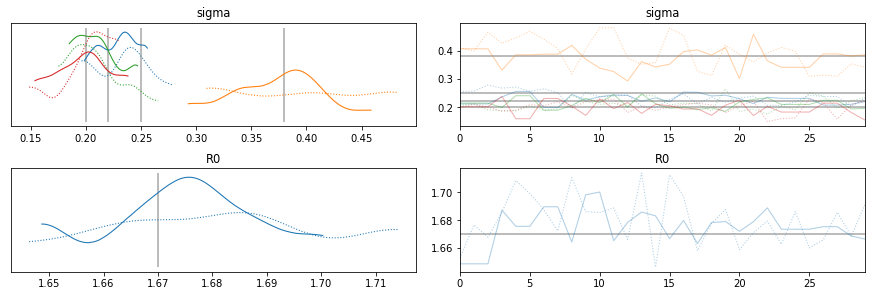

In [6]:
initial = [s0, i0, r0, d0] # vector of initial conditions

summary_0 = MCMC(sird_model=sird_model, # used for constructing
                                        # the curves in MCMC modeling
                 initial=initial, yobs=yobs,
                 sample_size=30, tune=10,
                 sigmas=sigmas, R0=R0) # true sigma and R nought values
                                       # are provided for the final graph
                                       # output so that the accuracy of
                                       # the model can be evaluated

### Analysis of output graphs in (0):
- As mentioned before, this section is intended only for demonstration, therefore a very small sample size (30) and tuning number (10) was used. 

- The two graphs on the left above represent the posterior distributions of the sigmas and $R_{0}$ (R nought) output by the MCMC model. The vertical lines in these two plots represent the true values of the parameters. It can be seen that the distributions output are all roughly around the true values. Therefore, even when given very few samples, the model was already able to approximately capture the parameters' true values.

- The two graphs on the right shows the changes of the parameters' values for each sample, and the horizontal lines in them represent the true values. A similar observation can be made for these two graphs: the model was able to approximately capture the true values of these parameters with a very small number of sample size.

## Start analysis by using function MCMC_model
### Note: 
Although there are many more combinations, only three cases are shown in this notebook. This is because after trying out other combinations, it appears that the differences between them are very small, which will be shown later.

In [7]:
import time
start_time = time.time()

## Case (1): Initial combination
In this case, Half Cauchy distribution is used for prior of sigma, and Bounded Normal distribution is used for prior of $R_{0}$ (R nought)

Only 400 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [R0, sigma]


Sampling 2 chains for 1_000 tune and 400 draw iterations (2_000 + 800 draws total) took 715 seconds.


Assuming the distributions of sigmas are Half Cauchy, and distribution of R0 is Bounded Normal.


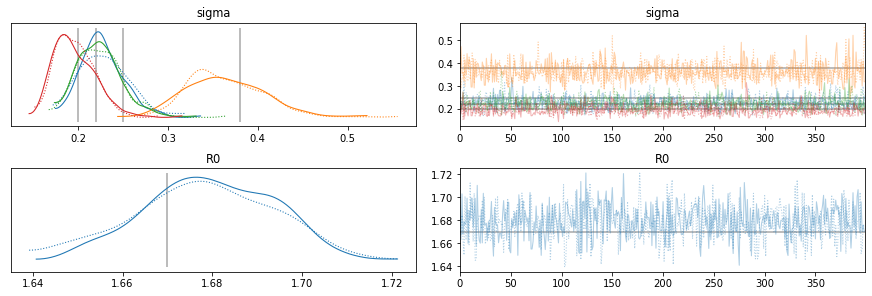

In [8]:
summary_1 = MCMC_model(sigma_prior=1, # 1 is the label of Half 
                                      # Cauchy distribution
                       sigma_param=1, # value of beta
                       R_prior=1, # 1 is the label of Bounded 
                                  # Normal distribution
                       R_param=[2,2.5], # values of mean and variance
                       sird_model=sird_model, 
                       initial=initial, yobs=yobs, 
                       sample_size=400, tune=1000, 
                       sigmas=sigmas, R0=R0)

#### Analysis of output graphs in (1):
- The two graphs on the left above represent the posterior distributions of the sigmas and $R_{0}$ (R nought) output by the MCMC model. The vertical lines in these two plots represent the true values of the parameters. It can be seen that the distributions output are all roughly around the true values. Moreover, compared with the case in (0) which has small sample size, these posteriors are smoother and have smaller variance between the two chains (represented by the solid and the dotted lines).

- The two graphs on the right shows the changes of the parameters' values for each sample, and the horizontal lines in them represent the true values. A similar observation can be made for these two graphs: the model was able to better capture the true values of these parameters with a larger sample size.

## Case (2): First variation - change the prior distribution for sigmas 
Prior distributions for sigmas are changed from Half Cauchy to Half Normal, while and their parameter values are changed from beta=1 to beta=1.5

Only 400 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [R0, sigma]


Sampling 2 chains for 1_000 tune and 400 draw iterations (2_000 + 800 draws total) took 702 seconds.


Assuming the distributions of sigmas are Half Normal, and distribution of R0 is Bounded Normal.


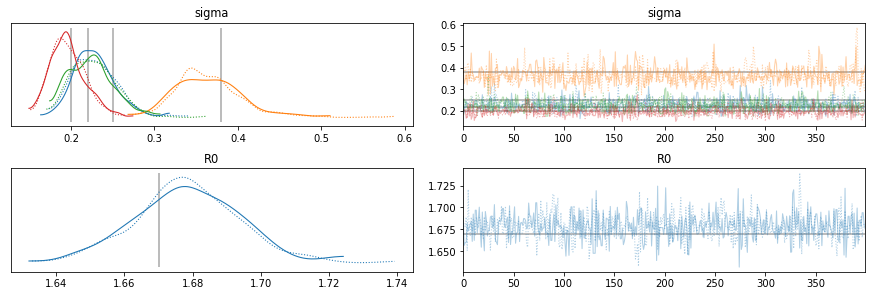

In [9]:
summary_2 = MCMC_model(sigma_prior=2, sigma_param=1.5, # change the prior 
                                                       # for sigmas
                       R_prior=1, R_param=[2,3], 
                       sird_model=sird_model, 
                       initial=initial, yobs=yobs, 
                       sample_size=400, tune=1000, 
                       sigmas=sigmas, R0=R0)

### Analysis of output graphs in (2):
- The two graphs on the left above represent the posterior distributions of the sigmas and $R_{0}$ (R nought) output by the MCMC model. The vertical lines in these two plots represent the true values of the parameters. By changing the prior distributions for the sigmas, the effect on the model's output is very little--the shapes of the posteriors as well as the relationship between the posteriors and the true values are barely changed.

- The two graphs on the right shows the changes of the parameters' values for each sample, and the horizontal lines in them represent the true values. A similar observation can be made for these two graphs: the model has shown very few changes compared to the graphs in (1) when the priors for sigmas are changed.

## Case (3): Second variation - change the prior distribution for $R_{0}$ 
The prior distribution for $R_{0}$ is changed from Bounded Normal to Bounded Lognormal, and its parameter values are changed from [mean=2, variance=2.5] to [mean=1.8, variance=2]

Only 400 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [R0, sigma]


Sampling 2 chains for 1_000 tune and 400 draw iterations (2_000 + 800 draws total) took 711 seconds.


Assuming the distributions of sigmas are Half Cauchy, and distribution of R0 is Bounded Lognormal.


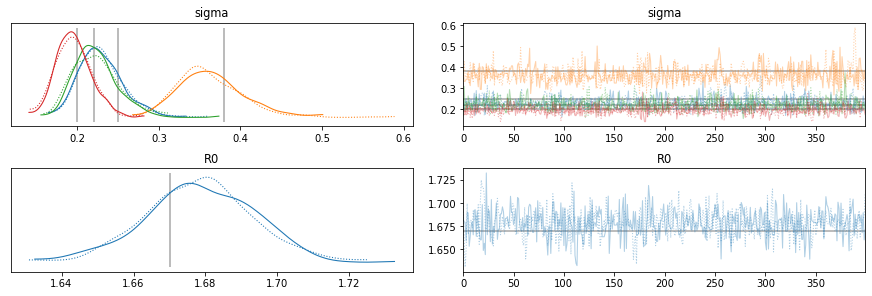

In [10]:
summary_3 = MCMC_model(sigma_prior=1, sigma_param=1, 
                       R_prior=2, R_param=[1.8,2], # change the prior for R0
                       sird_model=sird_model, 
                       initial=initial, yobs=yobs, 
                       sample_size=400, tune=1000, 
                       sigmas=sigmas, R0=R0)

### Analysis of output graphs in (3):
- The two graphs on the left above represent the posterior distributions of the sigmas and $R_{0}$ (R nought) output by the MCMC model. The vertical lines in these two plots represent the true values of the parameters. By changing the prior distributions for $R_{0}$ (R nought), the effect on the model's output is very little--the shapes of the posteriors as well as the relationship between the posteriors and the true values are barely changed.

- The two graphs on the right shows the changes of the parameters' values for each sample, and the horizontal lines in them represent the true values. A similar observation can be made for these two graphs: the model has shown very few changes compared to the graphs in (1) when the prior for $R_{0}$ (R nought) is changed.

In [11]:
end = time.time()
print("Time spent: ", end-start_time)

Time spent:  2626.4950189590454


## Initial conclusion based on analysis of the traceplots above:
By changing the priors for sigmas or changing the prior for $R_{0}$ (R nought), it appears that the results of the MCMC model have shown very small changes. Therefore, the next section will analyze the differences between these cases from a numerical perspective.

### Relate back to the summary tables for the three cases:
Results of the three runs are summarized in `summary_1` (initial case), `summary_2` (only changing sigmas priors), and `summary_3` (only changing $R_{0}$ prior)

As the traceplots showed previously, changing the distributions didn't lead to much improvement. Therefore, the changes in these summary tables are expected to be very limited. Therefore, for demonstration purpose, only the values of the `mean` column in these tables are used as the other columns are not so important here.

To evaluate these three cases, these `mean` values can be compared with their corresponding true values to see how close they are to each other.

In [12]:
# Construct a dataframe to store all the mean columns
mean_df = pd.concat([summary_1['mean'],
                     summary_2['mean'],
                     summary_3['mean']], 
                    axis=1)

# Rename columns
mean_df.columns=['Initial_case', '1st_variation', '2nd_variation']

# Insert a column for the corresponding true values
true_value = sigmas
true_value.append(R0)
mean_df['True_value'] = true_value

# Calculate the (absolute) differences between the mean values and
# their corresponding true values
for i in range(3):
    mean_df.iloc[:,i] = abs(mean_df.iloc[:,i]-mean_df['True_value'])

# Drop the true value column and visualize the differences of the
# three cases
mean_df = mean_df.drop('True_value', axis=1)
mean_df.style.background_gradient(cmap='PuBu', axis=1)

,Initial_case,1st_variation,2nd_variation
sigma[0],0.022000,0.022000,0.021000
sigma[1],0.016000,0.015000,0.017000
sigma[2],0.004000,0.006000,0.003000
sigma[3],0.004000,0.004000,0.004000
R0,0.012333,0.011333,0.011333


### Analysis of the summary tables:
After subtracting the true values from the mean values output by the three models and taking their absolute values (as the "absolute deviation" is the focus here), the cells are color coded as shown above based on the comparisons across each row (i.e. in the first row, the values 0.022, 0.022, and 0.021 are compared and since the first two are the highest, they are given a dark color). Again, the differences between the three cases are very small, as mentioned above. Even so, the third column, which has the fewest dark colored cells, have shown a (slight) advantage over the other cases.

# Part II. Study the effect of removing the S and R curves <a class="anchor" id="chapter3"></a>
In this part, the focus is on the curves fed into the MCMC models themselves instead of the model accuracy. Therefore, the same set of parameters of the model will be used. Since it has been shown previously that the different sets of parameters don't seem to make much difference, any of the three cases can be used. Here, the combination that we choose are:
1. Prior for sigmas: Half Cauchy with $\beta=1$
2. Prior for $R_{0}$ (R nought): Bounded Lognormal with mean=1.8 and sigma=2

To study the effect of removing the S and R curves, two cases are presented here:
1. Only removing the S curve. In this case, it is essentially the same as removing both S and R curves, the reason is shown as follows: as stated in the assumptions, $\beta$ and $\gamma$ have fixed values. Therefore, the value of $\mu$ can be inferred if the value of $R_{0}$ (R nought) is provided. As $$\frac{dR}{dt}=\frac{\gamma I}{N}$$ and $$\frac{dD}{dt}=\frac{\mu I}{N}$$---then if the I curve can be calculated, then given that $\mu$ can be inferred, even when R curve is not provided, it can still be calculated.


2. Only removing the R curve.

## Case (1): Removing S curve (keeping only I, R, and D curves)

In [13]:
del y, yobs, initial

initial = [d0, i0, r0]
sigmas_2 = [0.20, 0.38, 0.22] # sigmas of D, I, and R

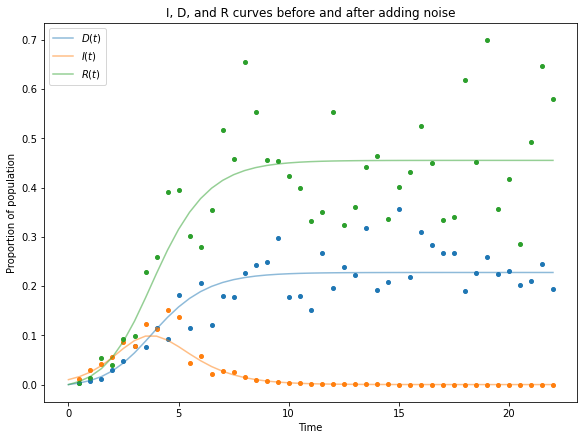

In [14]:
# Create I, R, and D curves
y = odeint(IRD, t=times, y0=[d0, i0, r0], 
           args=([2.5/(1+mu)],), rtol=1e-8)

yobs = np.zeros([len(times)-1,np.shape(y)[1]])
# To avoid cases where noise-added data points have values
# above 1, same process is performed as above in Part I
for i in range(np.shape(y)[1]):
    for j in range(len(times)-1):
        while True:
            yobs[j,i] = np.random.lognormal(mean=np.log(y[j+1,i]), 
                                            sigma=sigmas_2[i])
            if yobs[j,i]<=1: # check if the noise added data point is realistic
                break

# Plot the deterministic curves, and those with multiplicative noise
fig2, ax2 = plt.subplots(1,1,figsize=(8,6),constrained_layout=True)
ax2.plot(times[1::], yobs, marker='o', linestyle='none', markersize=4)
ax2.plot(times, y[:,0], color ='C0', alpha=0.5, label=f'$D(t)$')
ax2.plot(times, y[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
ax2.plot(times, y[:,2], color ='C2', alpha=0.5, label=f'$R(t)$')

ax2.legend()
ax2.set_title('I, D, and R curves before and after adding noise')
ax2.set_xlabel('Time')
ax2.set_ylabel('Proportion of population')

plt.show()

In [15]:
# ODE system container
ird_model = DifferentialEquation(
    func=IRD,
    times=np.arange(timestep_data, 5*f, 
                    timestep_data), # start at t=t_1 (not 
                                    # t0=0 where log(R=0)=undef)
    n_states=3, # I, R, and D are states
    n_theta=1, # R0 is the only parameter
    t0=0) # start from zero

Sequential sampling (2 chains in 1 job)
NUTS: [R0, sigma]


Sampling 2 chains for 1_000 tune and 600 draw iterations (2_000 + 1_200 draws total) took 642 seconds.


Assuming the distributions of sigmas are Half Cauchy, and distribution of R0 is Bounded Lognormal.


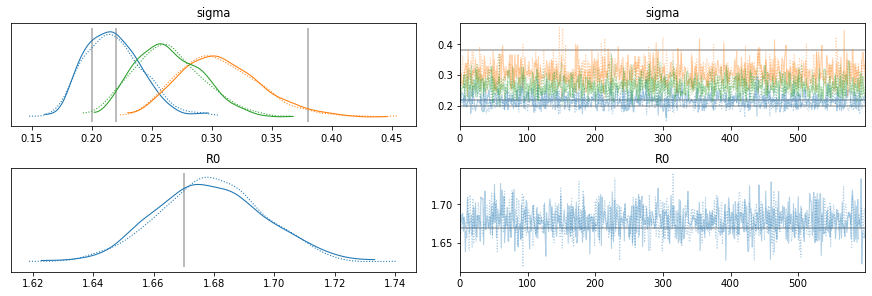

In [16]:
summary_4 = MCMC_model(sigma_prior=1, sigma_param=1, 
                       R_prior=2, R_param=[1.8,2], 
                       sird_model=ird_model, 
                       initial=initial, yobs=yobs, 
                       sample_size=600, # Sample size is increased as the number
                                        # of curves provided decreased
                       tune=1000, sigmas=sigmas_2, R0=R0)

### Analysis of output graphs in (1):
- The two graphs on the left above represent the posterior distributions of the sigmas and $R_{0}$ (R nought) output by the MCMC model. The vertical lines in these two plots represent the true values of the parameters. When only I, R, and D curves are provided, it appears that the posterior distirbutions of sigmas have performed more poorly compared to the ones in Part I where all four curves are provided. In comparison, the posterior distribution of $R_{0}$ (R nought) seems to have barely changed and can still approximately capture the true value.

- The two graphs on the right shows the changes of the parameters' values for each sample, and the horizontal lines in them represent the true values. A similar observation can be made for these two graphs: the model's performance is worse in the case of the sigma values, while in the case of $R_{0}$ (R nought), limited changes can be observed.

## Case (2): Removing R curve (keeping only S, I, and D curves)

In [17]:
del y, yobs, initial

initial = [s0, i0, d0]
sigmas_3 = [0.25, 0.38, 0.20]

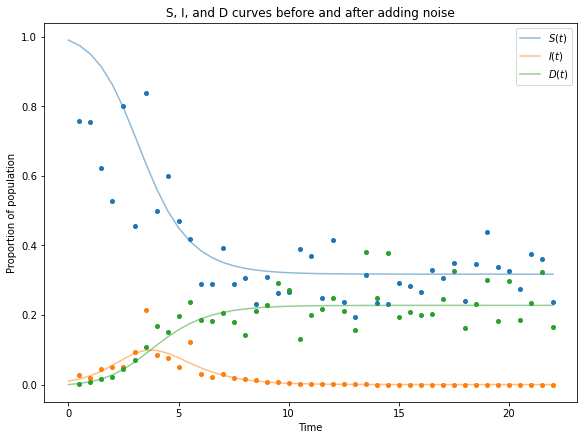

In [18]:
# Create S, I, and D curves
y = odeint(SID, t=times, y0=[s0, i0, d0], 
           args=([2.5/(1+mu)],), rtol=1e-8)

yobs = np.zeros([len(times)-1,np.shape(y)[1]])
# To avoid cases where noise-added data points have values
# above 1, same process is performed as above in Part I
for i in range(np.shape(y)[1]):
    for j in range(len(times)-1):
        while True:
            yobs[j,i] = np.random.lognormal(mean=np.log(y[j+1,i]), 
                                            sigma=sigmas_3[i])
            if yobs[j,i]<=1: # check if the noise added data point is realistic
                break

# Plot the deterministic curves, and those with multiplicative noise
fig3, ax3 = plt.subplots(1,1,figsize=(8,6),constrained_layout=True)
ax3.plot(times[1::], yobs, marker='o', linestyle='none', markersize=4)
ax3.plot(times, y[:,0], color ='C0', alpha=0.5, label=f'$S(t)$')
ax3.plot(times, y[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
ax3.plot(times, y[:,2], color ='C2', alpha=0.5, label=f'$D(t)$')

ax3.legend()
ax3.set_title('S, I, and D curves before and after adding noise')
ax3.set_xlabel('Time')
ax3.set_ylabel('Proportion of population')

plt.show()

In [19]:
# ODE system container
sid_model = DifferentialEquation(
    func=SID,
    times=np.arange(timestep_data, 5*f, 
                    timestep_data), # start at t=t_1 (not 
                                    # t0=0 where log(R=0)=undef)
    n_states=3, # S, I, and D are states
    n_theta=1, # R0 is the only parameter
    t0=0) # start from zero

Sequential sampling (2 chains in 1 job)
NUTS: [R0, sigma]


Sampling 2 chains for 1_000 tune and 600 draw iterations (2_000 + 1_200 draws total) took 656 seconds.


Assuming the distributions of sigmas are Half Cauchy, and distribution of R0 is Bounded Lognormal.


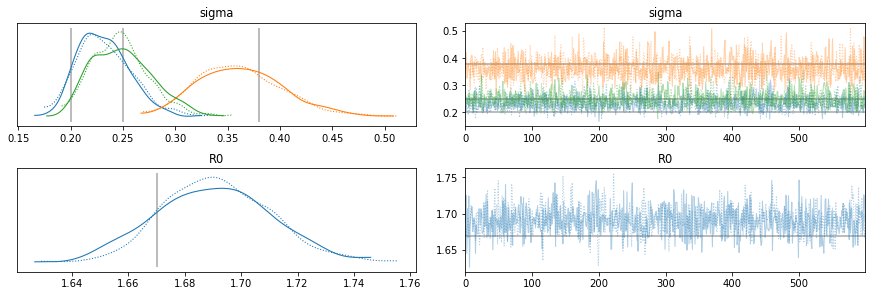

In [20]:
summary_5 = MCMC_model(sigma_prior=1, sigma_param=1, 
                       R_prior=2, R_param=[1.8,2], 
                       sird_model=sid_model, 
                       initial=initial, yobs=yobs, 
                       sample_size=600, # Sample size is increased as the number
                                        # of curves provided decreased
                       tune=1000, sigmas=sigmas_3, R0=R0)

### Analysis of output graphs in (2):
- The two graphs on the left above represent the posterior distributions of the sigmas and $R_{0}$ (R nought) output by the MCMC model. The vertical lines in these two plots represent the true values of the parameters. When only S, I, and D curves are provided, it appears that the posterior distirbutions of the sigmas are not very different from the ones in Part I where all four curves are provided. In comparison, the posterior distribution of $R_{0}$ (R nought) has shown more deviation from the true value.

- The two graphs on the right shows the changes of the parameters' values for each sample, and the horizontal lines in them represent the true values. A similar observation can be made for these two graphs: the model's performance is worse in the case of the $R_{0}$ (R nought) values, while in the case of the sigmas, limited changes can be observed.

# Conclusion <a class="anchor" id="chapter4"></a>

- As shown in Part I, where all four curves of S, I, R, and D are provided, the changes in the prior distributions of eigher sigmas or $R_{0}$ (R nought) have very limited effects on the MCMC model's performance. Therefore, if one intends to optimize the code here, one should approach from a perspective of improving the computing speed instead of the perspective of improving the model's output. As the computing times in this notebook are relatively acceptable, this optimization is therefore not considered at the moment. For future reference, one might try other available pakcages designed for MCMC that might allow for more efficient parallelized computing.


- As shown in Part II, where only 3 out of the previous 4 curves are provided, the MCMC model can still output a fairly accurate estimate of the $R_{0}$ (R nought). Since the values of $R_{0}$ (R nought) and death rate $\mu$ can be computed from each other (using $R_{0}$ (R nought) = $\frac {2.5}{1 + \mu}$), it can be concluded that with the removal of the S and/or R curves, the model can still infer the value of $\mu$ (although the accuracy might suffer as a result as shown in Part II's analysis).

    Meanwhile, it is interesting to see that for the two cases in Part II, different observations are made regarding the models' accuracy--compared with Part I, when the S curve is removed, the accuracy of sigmas predictions have dropped while the accuracy of $R_{0}$ (R nought) prediction shows very small changes, and when the R curve is removed, the effects are the opposite (the accuracy of sigmas predictions barely changed while the accuracy of $R_{0}$ (R nought) prediction decreased). At the moment we cannot come up with a reasonable explanation for this phenomenon, which can be one of the topics for future work.


- Other comments for future work: for simplicity, the noise adding process for the curves are performed separately without constraints. However, this is not realistic: even after adding noises, the four curves should add up to 1 at any time point.